In [1]:
import pandas as pd
from os.path import join, basename
from glob import glob
from scipy.stats import spearmanr
from sklearn.metrics import mean_absolute_error
import numpy as np
''''
SpeechFormer
'''
GROUP_BY_DATE = True
GROUP_SEPARATOR = "_"
PATIENT_GROUP_LOCATION_IN_FILENAME = 0
ID_LOCATION_IN_FILENAME = -7
SUBKLINISCHE_GRUPPE = "Subklinische_Gruppe"
TRUE = "true"
''''
    all recordings
'''
RESULTS_BASE = "/data/eihw-gpu2/pechleba/results/speechformer_adapter/"
BASELINE_BASE = "/data/eihw-gpu2/pechleba/results/speechformer_base/"
BASELINE_FOLDER = "all_recordings_ema_e60_es15"
RESULT_FOLDER = "all_recordings_ema_e60_es15"
''''

    answers only
'''
# RESULTS_BASE = "/data/eihw-gpu2/pechleba/results/speechformer_adapter/"
# BASELINE_BASE = "/data/eihw-gpu2/pechleba/results/speechformer_base/"
# BASELINE_FOLDER = "ema_e60_b32_lr0.0001_hubert12_updated"
# RESULT_FOLDER = "ema_e60_b32_lr0.0001_hubert12_updated"
''''
    neutral texts 
'''
''''
hyperformer all
'''
# GROUP_SEPARATOR = "/"
# GROUP_BY_DATE = True
# ID_LOCATION_IN_FILENAME = -2
# PATIENT_GROUP_LOCATION_IN_FILENAME = 4
# SUBKLINISCHE_GRUPPE = "Subklinische_Gruppe"
# TRUE = "selfRatingDepression"
''''
    meta data and neutral texts 
'''
# RESULTS_BASE = "/data/eihw-gpu2/pechleba/results/"
# BASELINE_BASE = "/data/eihw-gpu2/pechleba/ParaSpeChaD/results/"
# BASELINE_FOLDER = "wav2vec"
# RESULT_FOLDER = "gpu1/hyperformer++_all_meta_nt"
''''
    neutral texts 
'''
#RESULTS_BASE = "/data/eihw-gpu1/pechleba/results"
#BASELINE_BASE = "/data/eihw-gpu2/pechleba/ParaSpeChaD/results/"
#BASELINE_FOLDER = "wav2vec"
#RESULT_FOLDER = "hyperformer++_all_nt"
''''
    meta, nt, embedding
'''
#RESULTS_BASE = "/data/eihw-gpu2/pechleba/results"
#BASELINE_BASE = "/data/eihw-gpu2/pechleba/ParaSpeChaD/results/"
#BASELINE_FOLDER = "wav2vec"
#RESULT_FOLDER = "hyperformer++_all_nt_meta"


''''
hyperformer reapprasials
'''

#GROUP_BY_DATE = False
#PATIENT_GROUP_LOCATION_IN_FILENAME = 9
# ID_LOCATION_IN_FILENAME = -3

#SUBKLINISCHE_GRUPPE = "SubklinischeGruppe"
''''
    meta data 
'''
#RESULTS_BASE = "/data/eihw-gpu2/pechleba/results/"
#BASELINE_BASE = "/data/eihw-gpu2/pechleba/results/"
#BASELINE_FOLDER = "hyperformer++_reapprasial_depression"
#RESULT_FOLDER = "hyperformer++_reapprasial_meta_embedding"
''''
hyperformer reapprasials
    neutral texts 
'''
#RESULTS_BASE = "/data/eihw-gpu1/pechleba/results"
#BASELINE_BASE = "/data/eihw-gpu1/pechleba/results"
#BASELINE_FOLDER = "hyperformer++_reapprasial"
#RESULT_FOLDER = "hyperformer++_reapprasial_nt"
''''
hyperformer reapprasials
    meta data and neutral texts 
'''
#RESULTS_BASE = "/data/eihw-gpu2/pechleba/results/"
#BASELINE_BASE = "/data/eihw-gpu2/pechleba/results"
#BASELINE_FOLDER = "hyperformer++_reapprasial_depression"
#RESULT_FOLDER = "hyperformer++_reapprasial_meta_embedding"



"'\nhyperformer reapprasials\n    meta data and neutral texts \n"

In [2]:
def load_predictions(experiment, patient_groups=None, result_base_adjusted=None):
    predictions = {}
    if result_base_adjusted is None: 
        current_result_base = RESULTS_BASE 
    else: 
        current_result_base = result_base_adjusted
    fold_dirs = glob(f"{current_result_base}/{experiment}/*/")
    for fold_dir in fold_dirs:
        try:
            fold = int(fold_dir.split("/")[-2])
            fold_predictions = list(glob(f"{fold_dir}/*.csv"))[0]
            _predictions = parse_filename(pd.read_csv(fold_predictions))
            if patient_groups is not None:
                _predictions = _predictions[_predictions["patientGroup"].isin(patient_groups)]
            if not "true" in _predictions.columns:
                _predictions["true"] = _predictions[TRUE]
            predictions[fold] = _predictions
        except ValueError:
            print(f"{fold_dir} probably not a fold directory.")
    all_predictions = pd.concat(predictions.values())
    return predictions, all_predictions

def parse_filename(df):    
    

    # df["patientGroup"] = df["filename"].apply(lambda x: x.split("/")[-3])
    # df["ID"] = df["filename"].apply(lambda x: x.split("/")[-2])

    if GROUP_BY_DATE:
        if GROUP_SEPARATOR == "_":
            df["date"] = df["filename"].apply(lambda x: "_".join(basename(x).split("_")[3:-2]) if basename(x).startswith('Subklinische_Gruppe') else "_".join(basename(x).split("_")[2:-2]))
        else:
            df["date"] = df["filename"].apply(lambda x: "_".join(basename(x).split("_")[:-2]))

        df["Content"] = df["filename"].apply(
            lambda x: "_".join(basename(x).split("_")[-2:])
        )
    else:
        df["Content"] = df["filename"].apply(lambda x: x.split(GROUP_SEPARATOR)[PATIENT_GROUP_LOCATION_IN_FILENAME - 1: PATIENT_GROUP_LOCATION_IN_FILENAME + 1]) # TODO add 
    df["patientGroup"] = df["filename"].apply(lambda x: x.split(GROUP_SEPARATOR)[PATIENT_GROUP_LOCATION_IN_FILENAME])

    df["patientGroup"] = df["patientGroup"].apply(lambda x: SUBKLINISCHE_GRUPPE if x in SUBKLINISCHE_GRUPPE else x)

    df["ID"] = df["filename"].apply(lambda x: x.split(GROUP_SEPARATOR)[ID_LOCATION_IN_FILENAME])#PATIENT_GROUP_LOCATION_IN_FILENAME + 1
    return df
    
def session_mean(df):
    if GROUP_BY_DATE:
        return df.groupby(["ID", "date", "patientGroup"])[["true", "prediction"]].mean().reset_index()
    return df.groupby(["ID", "patientGroup"])[["true", "prediction"]].mean().reset_index()


def compute_metrics(df, group_by=[]):
    columns = ["ID", "prediction", "true"] + group_by
    speaker_spearman = df[["ID", "prediction", "true"]].groupby(["ID"]).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().mean()
    if group_by:
        grouped_speaker_spearman = df[columns].groupby(["ID"] + group_by).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().groupby(group_by).mean()
    return speaker_spearman, grouped_speaker_spearman


    
def compute_metrics_2(df, group_by=[]):
    columns = ["ID", "prediction", "true"] + group_by
    speaker_spearman = df[["ID", "prediction", "true"]].groupby(["ID"]).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().mean()
    mae = mean_absolute_error(df["true"], df["prediction"])
    
    if group_by:
        grouped_speaker_spearman = df[columns].groupby(["ID"] + group_by).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().groupby(group_by).mean()
        grouped_mae = df[columns].groupby(["ID"] + group_by).apply(lambda x: mean_absolute_error(x["true"], x["prediction"])).dropna().groupby(group_by).mean()
        return speaker_spearman, grouped_speaker_spearman, mae, grouped_mae
    else:
        return speaker_spearman, mae


In [3]:
predictions, all_predictions = load_predictions(BASELINE_FOLDER, result_base_adjusted=BASELINE_BASE)
print(BASELINE_FOLDER)
all_predictions.to_csv(BASELINE_BASE + BASELINE_FOLDER + "/evaluation/" + BASELINE_FOLDER + "_predictions.csv", index=False)

/data/eihw-gpu2/pechleba/results/speechformer_base//all_recordings_ema_e60_es15/evaluation/ probably not a fold directory.
all_recordings_ema_e60_es15


In [4]:
def print_metrics(metrics):
    metric_string = ""
    for key in sorted(metrics.keys()):
        metric_string += f" & {np.mean(metrics[key]):.3f} ({np.std(metrics[key]):.3f})"
    return metric_string + " \\\\"

def print_metrics_2(metrics, metrics_mae):
    metric_string = ""
    for key in sorted(metrics.keys()):
        metric_string += f" & {np.mean(metrics[key]):.3f}\(\pm\){np.std(metrics[key]):.3f} & {np.mean(metrics_mae[key]):.3f}\(\pm\){np.std(metrics_mae[key]):.3f}"
    return metric_string + " \\\\"

def general_metrics(experiment, result_base_adjusted=None):
    predictions_fold, predictions_all = load_predictions(experiment, result_base_adjusted=result_base_adjusted)
    metrics = {"All": [], "Kontrollgruppe": [], "PatientInnen": [], SUBKLINISCHE_GRUPPE: []}
    for predictions in predictions_fold.values():
        predictions_mean = session_mean(predictions)
        speaker_rho, grouped_speaker_rho = compute_metrics(predictions_mean, group_by=["patientGroup"])
        metrics["All"].append(speaker_rho)
        for name, value in zip(grouped_speaker_rho.index, grouped_speaker_rho.values):
            metrics[name].append(value)
    return metrics

def general_metrics_2(experiment, result_base_adjusted=None):
    predictions_fold, predictions_all = load_predictions(experiment, result_base_adjusted=result_base_adjusted)
    metrics = {"All": [], "Kontrollgruppe": [], "PatientInnen": [], SUBKLINISCHE_GRUPPE: []}
    metrics_mae = {"All": [], "Kontrollgruppe": [], "PatientInnen": [], SUBKLINISCHE_GRUPPE: []}
    for predictions in predictions_fold.values():
        predictions_mean = session_mean(predictions)
        speaker_rho, grouped_speaker_rho, mae, grouped_mae = compute_metrics_2(predictions_mean, group_by=["patientGroup"])
        metrics["All"].append(speaker_rho)
        metrics_mae["All"].append(mae)
        for name, value in zip(grouped_speaker_rho.index, grouped_speaker_rho.values):
            metrics[name].append(value)
        for name, value in zip(grouped_mae.index, grouped_mae.values):
            metrics_mae[name].append(value)
    return metrics, metrics_mae

def phrase_metrics(experiment):
    predictions_fold, predictions_all = load_predictions(experiment)
    metrics = {"All": {}, "Kontrollgruppe": {}, "PatientInnen": {}, SUBKLINISCHE_GRUPPE: {}}
    for predictions in predictions_fold.values():
        for content in predictions.Content.unique():
            _predictions = predictions[predictions.Content == content]
            speaker_rho, grouped_speaker_rho = compute_metrics(_predictions, group_by=["patientGroup"])
            if not content in metrics["All"]:
                metrics["All"][content] = []
            metrics["All"][content].append(speaker_rho)
            for name, value in zip(grouped_speaker_rho.index, grouped_speaker_rho.values):
                if not content in metrics[name]:
                    metrics[name][content] = []
                metrics[name][content].append(value)
    for group in metrics:
        for content in metrics[group]:
            metrics[group][content] = f"{np.mean(metrics[group][content]):.3f} ({np.std(metrics[group][content]):.3f})"
    return metrics

def type_metrics(experiment, folder=None):
    predictions_fold, predictions_all = load_predictions(experiment=experiment, result_base_adjusted=folder)
    metrics = {"All": {}, "Kontrollgruppe": {}, "PatientInnen": {}, SUBKLINISCHE_GRUPPE: {}}
    for predictions in predictions_fold.values():
        predictions["Content"] = predictions["Content"].apply(lambda x: "Frage" if "Frage" in x else "Antwort" if "Antwort" in x else "positiverGedanke" if "positiverGedanke" in x else "Garbage")
        if GROUP_BY_DATE:
            numeric_columns = ["true", "prediction"] 
            predictions = predictions.groupby(["ID", "patientGroup", "Content", "date"])[numeric_columns].mean().reset_index()
            # predictions = predictions.groupby(["ID", "date", "patientGroup", "Content"]).mean().reset_index()
        else:
            predictions = predictions.groupby(["ID", "patientGroup", "Content"]).mean().reset_index()
        for content in predictions.Content.unique():
            _predictions = predictions[predictions.Content == content]
            speaker_rho, grouped_speaker_rho = compute_metrics(_predictions, group_by=["patientGroup"])
            if not content in metrics["All"]:
                metrics["All"][content] = []
            metrics["All"][content].append(speaker_rho)
            for name, value in zip(grouped_speaker_rho.index, grouped_speaker_rho.values):
                if not content in metrics[name]:
                    metrics[name][content] = []
                metrics[name][content].append(value)
    for group in metrics:
        for content in metrics[group]:
            metrics[group][content] = f"{np.mean(metrics[group][content]):.3f} ({np.std(metrics[group][content]):.3f})"
    return metrics
    

In [5]:
# m = type_metrics("hyperformer++_all")
# print(pd.DataFrame(data=m).to_latex())

import warnings
from scipy.stats import ConstantInputWarning
warnings.filterwarnings('ignore', category=ConstantInputWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='scipy')
configs = [

    ("SpeechFormer++ Base", "all_recordings_ema_e60_es15", "/data/eihw-gpu2/pechleba/results/speechformer_base/"),
    ("SpeechFormer++ Depression Tests", "all_recordings_ema_e60_es15_adapter_depression_tests", "/data/eihw-gpu2/pechleba/results/speechformer_adapter/"),
    ("SpeechFormer++ NT", "all_recordings_ema_e60_es15_adapter_nt", "/data/eihw-gpu2/pechleba/results/speechformer_adapter/"),
    ("SpeechFormer++ Embeddings", "all_recordings_ema_e60_es15_adapter_embeddings", "/data/eihw-gpu2/pechleba/results/speechformer_adapter/"),
    ("SpeechFormer++ Depression Tests & Embedding", "all_recordings_ema_e60_es15_adapter_depression_tests_embedding", "/data/eihw-gpu2/pechleba/results/speechformer_adapter/"),
    ("SpeechFormer++ Depression Tests & NT", "all_recordings_ema_e60_es15_adapter_depression_tests_nt", "/data/eihw-gpu2/pechleba/results/speechformer_adapter/"),
    ("SpeechFormer++ Depression Tests & NT & Embeddings", "all_recordings_ema_e60_es15_adapter_depression_tests_nt_embeddings", "/data/eihw-gpu2/pechleba/results/speechformer_adapter/"),

    ("SpeechFormer++ Base ES = 40 Epochs", "all_recordings_ema_e60_es40", "/data/eihw-gpu2/pechleba/results/speechformer_base/"),
    ("SpeechFormer++ Depression Tests ES = 40 Epochs", "all_recordings_ema_e60_es40_adapter_depression_tests", "/data/eihw-gpu2/pechleba/results/speechformer_adapter/"),
    ("SpeechFormer++ Depression Tests & NT ES = 40 Epochs", "all_recordings_ema_e60_es40_adapter_depression_tests_nt", "/data/eihw-gpu2/pechleba/results/speechformer_adapter/"),
]

for name, folder, base in configs:
    print(name)

    m = type_metrics(experiment=folder, folder=base)
    print(pd.DataFrame(data=m).to_latex())


SpeechFormer++ Base
/data/eihw-gpu2/pechleba/results/speechformer_base//all_recordings_ema_e60_es15/evaluation/ probably not a fold directory.


/tmp/ipykernel_783288/4223193179.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  speaker_spearman = df[["ID", "prediction", "true"]].groupby(["ID"]).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().mean()
/tmp/ipykernel_783288/4223193179.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_speaker_spearman = df[columns].groupby(["ID"] + group_by).apply(lambda x: spearmanr(x["p

\begin{tabular}{lllll}
\toprule
 & All & Kontrollgruppe & PatientInnen & Subklinische_Gruppe \\
\midrule
Antwort & 0.339 (0.066) & 0.295 (0.076) & 0.366 (0.085) & 0.337 (0.103) \\
Frage & 0.174 (0.052) & 0.127 (0.075) & 0.179 (0.079) & 0.203 (0.038) \\
positiverGedanke & 0.196 (0.038) & 0.181 (0.059) & 0.220 (0.058) & 0.181 (0.043) \\
\bottomrule
\end{tabular}

SpeechFormer++ Depression Tests
/data/eihw-gpu2/pechleba/results/speechformer_adapter//all_recordings_ema_e60_es15_adapter_depression_tests/evaluation/ probably not a fold directory.


/tmp/ipykernel_783288/4223193179.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  speaker_spearman = df[["ID", "prediction", "true"]].groupby(["ID"]).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().mean()
/tmp/ipykernel_783288/4223193179.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_speaker_spearman = df[columns].groupby(["ID"] + group_by).apply(lambda x: spearmanr(x["p

\begin{tabular}{lllll}
\toprule
 & All & Kontrollgruppe & PatientInnen & Subklinische_Gruppe \\
\midrule
Antwort & 0.396 (0.048) & 0.355 (0.079) & 0.435 (0.021) & 0.391 (0.101) \\
Frage & 0.236 (0.059) & 0.163 (0.074) & 0.271 (0.055) & 0.245 (0.094) \\
positiverGedanke & 0.229 (0.041) & 0.164 (0.080) & 0.281 (0.042) & 0.209 (0.080) \\
\bottomrule
\end{tabular}

SpeechFormer++ NT


/tmp/ipykernel_783288/4223193179.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  speaker_spearman = df[["ID", "prediction", "true"]].groupby(["ID"]).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().mean()
/tmp/ipykernel_783288/4223193179.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_speaker_spearman = df[columns].groupby(["ID"] + group_by).apply(lambda x: spearmanr(x["p

\begin{tabular}{lllll}
\toprule
 & All & Kontrollgruppe & PatientInnen & Subklinische_Gruppe \\
\midrule
Antwort & 0.325 (0.066) & 0.270 (0.091) & 0.344 (0.068) & 0.341 (0.114) \\
Frage & 0.174 (0.052) & 0.128 (0.073) & 0.173 (0.088) & 0.202 (0.034) \\
positiverGedanke & 0.184 (0.041) & 0.156 (0.045) & 0.227 (0.063) & 0.155 (0.045) \\
\bottomrule
\end{tabular}

SpeechFormer++ Embeddings


/tmp/ipykernel_783288/4223193179.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  speaker_spearman = df[["ID", "prediction", "true"]].groupby(["ID"]).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().mean()
/tmp/ipykernel_783288/4223193179.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_speaker_spearman = df[columns].groupby(["ID"] + group_by).apply(lambda x: spearmanr(x["p

\begin{tabular}{lllll}
\toprule
 & All & Kontrollgruppe & PatientInnen & Subklinische_Gruppe \\
\midrule
Antwort & 0.384 (0.060) & 0.332 (0.070) & 0.415 (0.052) & 0.386 (0.097) \\
Frage & 0.245 (0.060) & 0.175 (0.095) & 0.282 (0.072) & 0.248 (0.074) \\
positiverGedanke & 0.217 (0.030) & 0.173 (0.068) & 0.275 (0.039) & 0.187 (0.052) \\
\bottomrule
\end{tabular}

SpeechFormer++ Depression Tests & Embedding


/tmp/ipykernel_783288/4223193179.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  speaker_spearman = df[["ID", "prediction", "true"]].groupby(["ID"]).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().mean()
/tmp/ipykernel_783288/4223193179.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_speaker_spearman = df[columns].groupby(["ID"] + group_by).apply(lambda x: spearmanr(x["p

\begin{tabular}{lllll}
\toprule
 & All & Kontrollgruppe & PatientInnen & Subklinische_Gruppe \\
\midrule
Antwort & 0.404 (0.054) & 0.358 (0.064) & 0.427 (0.037) & 0.419 (0.105) \\
Frage & 0.248 (0.046) & 0.181 (0.088) & 0.274 (0.048) & 0.266 (0.068) \\
positiverGedanke & 0.238 (0.032) & 0.183 (0.076) & 0.288 (0.031) & 0.217 (0.059) \\
\bottomrule
\end{tabular}

SpeechFormer++ Depression Tests & NT


/tmp/ipykernel_783288/4223193179.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  speaker_spearman = df[["ID", "prediction", "true"]].groupby(["ID"]).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().mean()
/tmp/ipykernel_783288/4223193179.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_speaker_spearman = df[columns].groupby(["ID"] + group_by).apply(lambda x: spearmanr(x["p

\begin{tabular}{lllll}
\toprule
 & All & Kontrollgruppe & PatientInnen & Subklinische_Gruppe \\
\midrule
Antwort & 0.384 (0.059) & 0.331 (0.062) & 0.404 (0.065) & 0.395 (0.112) \\
Frage & 0.219 (0.052) & 0.159 (0.084) & 0.242 (0.075) & 0.233 (0.055) \\
positiverGedanke & 0.222 (0.029) & 0.182 (0.047) & 0.270 (0.047) & 0.195 (0.043) \\
\bottomrule
\end{tabular}

SpeechFormer++ Depression Tests & NT & Embeddings


/tmp/ipykernel_783288/4223193179.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  speaker_spearman = df[["ID", "prediction", "true"]].groupby(["ID"]).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().mean()
/tmp/ipykernel_783288/4223193179.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_speaker_spearman = df[columns].groupby(["ID"] + group_by).apply(lambda x: spearmanr(x["p

\begin{tabular}{lllll}
\toprule
 & All & Kontrollgruppe & PatientInnen & Subklinische_Gruppe \\
\midrule
Antwort & 0.336 (0.066) & 0.288 (0.082) & 0.353 (0.080) & 0.344 (0.115) \\
Frage & 0.173 (0.061) & 0.115 (0.096) & 0.199 (0.094) & 0.179 (0.028) \\
positiverGedanke & 0.188 (0.026) & 0.165 (0.036) & 0.231 (0.047) & 0.156 (0.040) \\
\bottomrule
\end{tabular}

SpeechFormer++ Base ES = 40 Epochs


/tmp/ipykernel_783288/4223193179.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  speaker_spearman = df[["ID", "prediction", "true"]].groupby(["ID"]).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().mean()
/tmp/ipykernel_783288/4223193179.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_speaker_spearman = df[columns].groupby(["ID"] + group_by).apply(lambda x: spearmanr(x["p

\begin{tabular}{lllll}
\toprule
 & All & Kontrollgruppe & PatientInnen & Subklinische_Gruppe \\
\midrule
Antwort & 0.348 (0.054) & 0.321 (0.093) & 0.381 (0.074) & 0.339 (0.108) \\
Frage & 0.179 (0.045) & 0.107 (0.057) & 0.221 (0.102) & 0.181 (0.063) \\
positiverGedanke & 0.167 (0.041) & 0.158 (0.084) & 0.214 (0.065) & 0.133 (0.062) \\
\bottomrule
\end{tabular}

SpeechFormer++ Depression Tests ES = 40 Epochs


/tmp/ipykernel_783288/4223193179.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  speaker_spearman = df[["ID", "prediction", "true"]].groupby(["ID"]).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().mean()
/tmp/ipykernel_783288/4223193179.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_speaker_spearman = df[columns].groupby(["ID"] + group_by).apply(lambda x: spearmanr(x["p

\begin{tabular}{lllll}
\toprule
 & All & Kontrollgruppe & PatientInnen & Subklinische_Gruppe \\
\midrule
Antwort & 0.381 (0.056) & 0.364 (0.035) & 0.393 (0.044) & 0.381 (0.126) \\
Frage & 0.220 (0.061) & 0.140 (0.064) & 0.266 (0.051) & 0.222 (0.099) \\
positiverGedanke & 0.215 (0.061) & 0.216 (0.045) & 0.250 (0.050) & 0.185 (0.102) \\
\bottomrule
\end{tabular}

SpeechFormer++ Depression Tests & NT ES = 40 Epochs


/tmp/ipykernel_783288/4223193179.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  speaker_spearman = df[["ID", "prediction", "true"]].groupby(["ID"]).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().mean()
/tmp/ipykernel_783288/4223193179.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_speaker_spearman = df[columns].groupby(["ID"] + group_by).apply(lambda x: spearmanr(x["p

\begin{tabular}{lllll}
\toprule
 & All & Kontrollgruppe & PatientInnen & Subklinische_Gruppe \\
\midrule
Antwort & 0.352 (0.054) & 0.317 (0.074) & 0.376 (0.065) & 0.352 (0.096) \\
Frage & 0.197 (0.062) & 0.148 (0.108) & 0.226 (0.101) & 0.202 (0.054) \\
positiverGedanke & 0.177 (0.048) & 0.161 (0.086) & 0.223 (0.090) & 0.145 (0.031) \\
\bottomrule
\end{tabular}



/tmp/ipykernel_783288/4223193179.py:57: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_speaker_spearman = df[columns].groupby(["ID"] + group_by).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().groupby(group_by).mean()
/tmp/ipykernel_783288/4223193179.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  speaker_spearman = df[["ID", "prediction", "true"]].groupby(["ID"]).apply(lambda

In [7]:
# m = phrase_metrics("hyperformer++_all")
m = phrase_metrics(RESULT_FOLDER)
print(pd.DataFrame(data=m).to_latex())

ValueError: No objects to concatenate

In [ ]:
predictions = list(glob(join(RESULTS_BASE, RESULT_FOLDER, "**/*.csv")))
predictions_df = pd.concat([pd.read_csv(csv) for csv in predictions])
#predictions_df.to_csv("predictions_"+RESULT_FOLDER+"_hyperformer.csv", index=False)

ValueError: No objects to concatenate

/data/eihw-gpu2/pechleba/results/speechformer_base//all_recordings_ema_e60_es15/evaluation/ probably not a fold directory.
/data/eihw-gpu2/pechleba/results/speechformer_adapter//all_recordings_ema_e60_es15_adapter_depression_tests/evaluation/ probably not a fold directory.
                                               filename  prediction  true  \
0     Kontrollgruppe_KU0765_2021-04-27_19_05_38.1320...    1.382399   0.0   
1     Kontrollgruppe_KU0765_2021-04-26_12_56_00.1530...    0.528857   0.0   
2     Kontrollgruppe_KU0765_2021-04-26_09_00_59.6440...    2.661066   0.0   
3     Kontrollgruppe_KU0765_2021-05-01_18_35_53.5420...    0.221310   0.0   
4     Kontrollgruppe_KU0765_2021-05-04_22_55_03.7160...    0.465714   0.0   
...                                                 ...         ...   ...   
9743  PatientInnen_JW0854_2021-10-24_09_33_53.236000...    0.466248   7.0   
9744  PatientInnen_JW0854_2021-10-06_10_28_36.628000...    0.187480   5.0   
9745  Subklinische_Gruppe_CG0255_

/tmp/ipykernel_783288/68165291.py:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: spearmanr(x["prediction"], x[TRUE])[0])
/data/eihw-gpu1/pechleba/SpeechFormer/.devenv/state/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/eihw-gpu1/pechleba/SpeechFormer/.devenv/state/venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/data/eihw-gpu1/pechleba/SpeechFormer/.devenv/state/venv/lib/python3.10/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom

Empty DataFrame
Columns: [ID, Experiment, Spearman's ρ]
Index: []
nan nan
138
nan nan


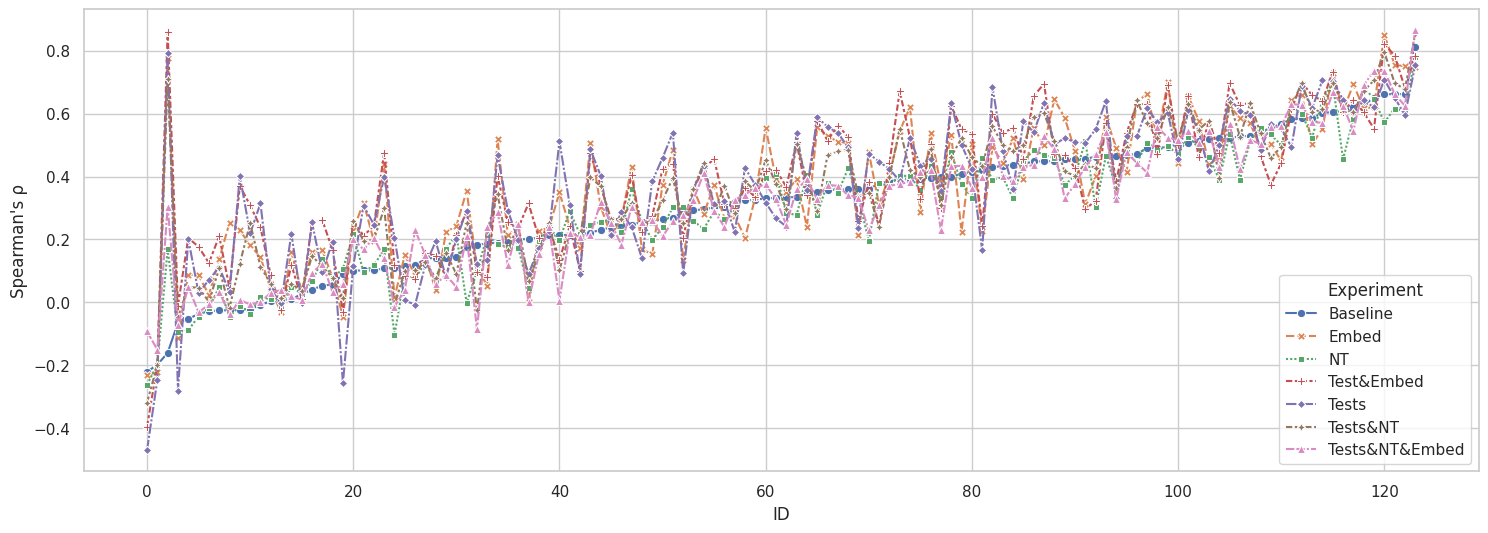

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

groups = ["Kontrollgruppe", SUBKLINISCHE_GRUPPE, "PatientInnen" ]
configs = [

    ("Baseline", "all_recordings_ema_e60_es15", "/data/eihw-gpu2/pechleba/results/speechformer_base/"),
    ("Tests", "all_recordings_ema_e60_es15_adapter_depression_tests", "/data/eihw-gpu2/pechleba/results/speechformer_adapter/"),
    ("NT", "all_recordings_ema_e60_es15_adapter_nt", "/data/eihw-gpu2/pechleba/results/speechformer_adapter/"),
    ("Embed", "all_recordings_ema_e60_es15_adapter_embeddings", "/data/eihw-gpu2/pechleba/results/speechformer_adapter/"),
    ("Test&Embed", "all_recordings_ema_e60_es15_adapter_depression_tests_embedding", "/data/eihw-gpu2/pechleba/results/speechformer_adapter/"),
    ("Tests&NT", "all_recordings_ema_e60_es15_adapter_depression_tests_nt", "/data/eihw-gpu2/pechleba/results/speechformer_adapter/"),
    ("Tests&NT&Embed", "all_recordings_ema_e60_es15_adapter_depression_tests_nt_embeddings", "/data/eihw-gpu2/pechleba/results/speechformer_adapter/"),

    # ("SpeechFormer++ Base ES = 40 Epochs", "all_recordings_ema_e60_es40", "/data/eihw-gpu2/pechleba/results/speechformer_base/"),
    # ("SpeechFormer++ Depression Tests ES = 40 Epochs", "all_recordings_ema_e60_es40_adapter_depression_tests", "/data/eihw-gpu2/pechleba/results/speechformer_adapter/"),
    # ("SpeechFormer++ Depression Tests & NT ES = 40 Epochs", "all_recordings_ema_e60_es40_adapter_depression_tests_nt", "/data/eihw-gpu2/pechleba/results/speechformer_adapter/"),
]

    # ("Baseline", "wav2vec", "/data/eihw-gpu2/pechleba/ParaSpeChaD/results/"),
    # ("Hyperformer meta", "hyperformer++_all","/data/eihw-gpu2/pechleba/results/"),
    # ("Hyperformer nt", "hyperformer++_all_nt", "/data/eihw-gpu2/pechleba/results/gpu1/"),
    # ("Hyperformer meta nt", "hyperformer++_all_meta_nt", "/data/eihw-gpu2/pechleba/results/gpu1/"),
    # ("Hyperformer meta nt embedding", "hyperformer++_ema_meta_nt_embedding", "/data/eihw-gpu2/pechleba/results/"),

    #("Hyperformer EMA Meta", "hyperformer++_all", "/data/eihw-gpu5/gerczuma/ParaSpeChaD/results/EMA/selfRatingDepression"),
    #("Baseline", "DL/wav2vec", "/data/eihw-gpu5/gerczuma/ParaSpeChaD/results/EMA/selfRatingDepression"),
    #("Baseline", "hyperformer++_all_nt", "/data/eihw-gpu1/pechleba/results"),
    #("Hyperformer EMA Embedding Meta", "hyperformer++_all_meta_nt", "/data/eihw-gpu1/pechleba/results")
    
    #("Hyperformer Reapprasial NT", "hyperformer++_reapprasial_nt", RESULTS_BASE),
    #("Hyperformer Reapprasial META NT", "hyperformer++_reapprasial_meta_nt_depression", RESULTS_BASE)

predictions_list = []
for name, path, result_base_adjusted in configs:
    _, predictions = load_predictions(path, patient_groups=groups, result_base_adjusted=result_base_adjusted)

    # if "Hyperformer" in name:
    #     name = "Hyperformer"
    predictions["Experiment"] = name
    predictions_list.append(predictions)

predictions = pd.concat(predictions_list)

predictions = predictions[predictions.patientGroup.isin(groups)]
print(predictions)
if GROUP_BY_DATE:
    num_values = ["true", "prediction"]
    predictions = (
        predictions.groupby(["ID", "Experiment", "date", "patientGroup"])[num_values]
        .mean()
        .reset_index()
    )

predictions = (
    predictions[["ID", "Experiment", "prediction", TRUE]]
    .groupby(["ID", "Experiment"])
    .apply(lambda x: spearmanr(x["prediction"], x[TRUE])[0])
    .sort_values()
    .sort_index(level="Experiment", sort_remaining=False)
    .reset_index()
)

if GROUP_SEPARATOR == "_":      # TODO make check if speechformer

    predictions_for_avg = predictions

    predictions_for_avg.columns = ["ID", "Experiment", "Spearman's ρ"]
    nan_rows = predictions_for_avg[predictions_for_avg["Spearman's ρ"].isna()]

    predictions_for_avg = predictions_for_avg[~predictions_for_avg.index.isin(nan_rows.index)]


    ids_in_meta_nt = predictions[predictions['Experiment'] == 'SpeechFormer++ Baseline']['ID'].unique()



    predictions_baseline_avg = predictions_for_avg[
        predictions_for_avg.Experiment == "SpeechFormer++ Base"].sort_values(
        by="ID"
    )

    print(str(predictions_baseline_avg))

    print(np.mean(predictions_baseline_avg["Spearman\'s ρ"].values), np.std(predictions_baseline_avg["Spearman\'s ρ"].values))


else:
    
    predictions_for_avg = predictions
    
    predictions_for_avg.columns = ["ID", "Experiment", "Spearman's ρ"]
    nan_rows = predictions_for_avg[predictions_for_avg["Spearman's ρ"].isna()]

    predictions_for_avg = predictions_for_avg[~predictions_for_avg.index.isin(nan_rows.index)]

    ids_in_embedding_meta = predictions[predictions['Experiment'] == 'Hyperformer EMA Embedding Meta']['ID'].unique()
    ids_in_meta_nt = predictions[predictions['Experiment'] == 'Baseline']['ID'].unique()
    #ids_not_in_meta_nt = set(ids_in_meta_nt) -set(ids_in_embedding_meta)

    predictions_baseline_avg = predictions_for_avg[
        predictions_for_avg.Experiment == "Baseline"].sort_values(
        by="ID"
    )

    for name, path, result_base_adjusted in configs:
        if name != "Baseline":
            print(name)
            print("_____________________________")
            predictions_hyperformer_avg = predictions_for_avg[
                predictions.Experiment == name
            ].sort_values(by="ID")
            common_indices = predictions_baseline_avg.index[predictions_baseline_avg["ID"].isin(predictions_hyperformer_avg["ID"])]
            predictions_baseline_avg = predictions_baseline_avg.loc[common_indices]
            print(np.mean(predictions_baseline_avg["Spearman\'s ρ"].values), np.std(predictions_baseline_avg["Spearman\'s ρ"].values))
            print(np.mean(predictions_hyperformer_avg["Spearman\'s ρ"].values), np.std(predictions_hyperformer_avg["Spearman\'s ρ"].values))

            help = predictions_baseline_avg["Spearman's ρ"].values

            predictions_baseline_avg["Diff"] = (
                predictions_hyperformer_avg["Spearman's ρ"].values
                - help
            )

            print(
                f"Mean diff: {predictions_baseline_avg['Diff'].mean()} ({np.std(predictions_baseline_avg['Diff'])})"
            )
            print("______________________________")

# print((predictions["ID"].values))
print(len(set(predictions["ID"].values)))
predictions["ID"] = pd.factorize(predictions["ID"].values, sort=False)[0]

predictions_hyperformer = predictions[
    predictions.Experiment == "SpeechFormer++ Base"
].sort_values(by="ID")

predictions.columns = ["ID", "Experiment", "Spearman's ρ"]
predictions_baseline = predictions[predictions.Experiment == "Baseline"].sort_values(
    by="ID"
)

predictions_hyperformer = predictions[
    predictions.Experiment == "SpeechFormer++ adapter"
].sort_values(by="ID")



predictions_hyperformer.sort_values(by="Spearman's ρ").to_csv("name.csv", index=False)
sns.set_theme(style="whitegrid", rc={"figure.figsize": (18, 6)})
sns.lineplot(
    data=predictions,
    x="ID",
    y="Spearman's ρ",
    hue="Experiment",
    style="Experiment",
    markers=True,
)
predictions_hyperformer.columns = ["ID", "Experiment", "Spearman's ρ"]

nan_rows = predictions_hyperformer[predictions_hyperformer["Spearman's ρ"].isna()]

predictions_hyperformer = predictions_hyperformer[~predictions_hyperformer.index.isin(nan_rows.index)]

print(np.mean(predictions_hyperformer["Spearman\'s ρ"].values), np.std(predictions_hyperformer["Spearman\'s ρ"].values))


plt.savefig(f"speaker_performance_{RESULT_FOLDER.split('/')[-1]}_{'_'.join(groups)}.pdf")


In [13]:

table_contents = []
for name, path, result_base_adjusted in configs:
    m, mae = general_metrics_2(path, result_base_adjusted=result_base_adjusted)

    table_contents.append(f"{name} {print_metrics_2(m, mae)}")
print("\n".join(table_contents))


/data/eihw-gpu2/pechleba/results/speechformer_base//all_recordings_ema_e60_es15/evaluation/ probably not a fold directory.


/tmp/ipykernel_92388/4223193179.py:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  speaker_spearman = df[["ID", "prediction", "true"]].groupby(["ID"]).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().mean()
/tmp/ipykernel_92388/4223193179.py:68: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_speaker_spearman = df[columns].groupby(["ID"] + group_by).apply(lambda x: spearmanr(x["pre

/data/eihw-gpu2/pechleba/results/speechformer_adapter//all_recordings_ema_e60_es15_adapter_depression_tests/evaluation/ probably not a fold directory.


/tmp/ipykernel_92388/4223193179.py:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  speaker_spearman = df[["ID", "prediction", "true"]].groupby(["ID"]).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().mean()
/tmp/ipykernel_92388/4223193179.py:68: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_speaker_spearman = df[columns].groupby(["ID"] + group_by).apply(lambda x: spearmanr(x["pre

Baseline  & 0.309\(\pm\)0.061 & 1.710\(\pm\)0.218 & 0.261\(\pm\)0.077 & 0.966\(\pm\)0.464 & 0.339\(\pm\)0.082 & 2.685\(\pm\)0.435 & 0.316\(\pm\)0.067 & 1.422\(\pm\)0.335 \\
Tests  & 0.367\(\pm\)0.060 & 1.130\(\pm\)0.141 & 0.298\(\pm\)0.082 & 0.391\(\pm\)0.093 & 0.419\(\pm\)0.050 & 1.999\(\pm\)0.141 & 0.362\(\pm\)0.108 & 0.953\(\pm\)0.152 \\
NT  & 0.300\(\pm\)0.060 & 1.882\(\pm\)0.264 & 0.259\(\pm\)0.076 & 1.204\(\pm\)0.667 & 0.325\(\pm\)0.085 & 2.720\(\pm\)0.346 & 0.302\(\pm\)0.066 & 1.580\(\pm\)0.436 \\
Embed  & 0.362\(\pm\)0.054 & 1.717\(\pm\)0.250 & 0.298\(\pm\)0.071 & 0.915\(\pm\)0.261 & 0.411\(\pm\)0.054 & 2.883\(\pm\)0.444 & 0.359\(\pm\)0.075 & 1.264\(\pm\)0.244 \\
Test&Embed  & 0.381\(\pm\)0.047 & 1.737\(\pm\)0.180 & 0.314\(\pm\)0.074 & 0.933\(\pm\)0.256 & 0.422\(\pm\)0.036 & 2.968\(\pm\)0.378 & 0.391\(\pm\)0.090 & 1.247\(\pm\)0.245 \\
Tests&NT  & 0.353\(\pm\)0.056 & 1.649\(\pm\)0.222 & 0.294\(\pm\)0.067 & 0.806\(\pm\)0.146 & 0.391\(\pm\)0.075 & 2.844\(\pm\)0.470 & 0.355\(\pm\)0

/tmp/ipykernel_92388/4223193179.py:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  speaker_spearman = df[["ID", "prediction", "true"]].groupby(["ID"]).apply(lambda x: spearmanr(x["prediction"], x["true"])[0]).dropna().mean()
/tmp/ipykernel_92388/4223193179.py:68: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_speaker_spearman = df[columns].groupby(["ID"] + group_by).apply(lambda x: spearmanr(x["pre

In [14]:

#df, metadata = pyreadstat.read_sav("/data/eihw-gpu2/pechleba/ParaSpeChaD/metadata/Alle_Daten_bis_t2.sav")
df = pd.read_csv("/data/eihw-gpu2/pechleba/ParaSpeChaD/metadata/fixed_merged_file.csv")

long_dfs = []
wide_df_2 = df.copy()
groups = ["Kontrollgruppe", SUBKLINISCHE_GRUPPE, "PatientInnen" ]



for j, (name, path, result_base_adjusted) in enumerate(configs):
    # _, predictions_hyperformer = load_predictions(path, result_base_adjusted=result_base_adjusted)
    folded_predictions, _ = load_predictions(path, patient_groups=groups, result_base_adjusted=result_base_adjusted)

    num_values = ["true", "prediction"]
    for i, predictions_hyperformer in folded_predictions.items():
        predictions_hyperformer = (
            predictions_hyperformer.groupby(["ID", "date", "patientGroup"])[num_values]
            .mean()
            .reset_index()
        )
        predictions_hyperformer = predictions_hyperformer[["ID", "prediction", "true"]]
        predictions_hyperformer_long = predictions_hyperformer.copy()
        predictions_hyperformer_long["Experiment"] = name
        predictions_hyperformer_long["fold"] = i
        long_dfs.append(predictions_hyperformer_long)
        if j == 0:
            predictions_hyperformer_long = predictions_hyperformer_long.copy()
            predictions_hyperformer_long["Experiment"] = "Groundtruth"
            predictions_hyperformer_long["prediction"] = predictions_hyperformer_long["true"]
            long_dfs.append(predictions_hyperformer_long)

    # predictions_hyperformer[name] = predictions_hyperformer[0]
    # wide_df = pd.merge(predictions_hyperformer, wide_df, left_on="ID", right_on="Code")
long_df = pd.merge(pd.concat(long_dfs), df, left_on="ID", right_on="Code")





/data/eihw-gpu2/pechleba/results/speechformer_base//all_recordings_ema_e60_es15/evaluation/ probably not a fold directory.
/data/eihw-gpu2/pechleba/results/speechformer_adapter//all_recordings_ema_e60_es15_adapter_depression_tests/evaluation/ probably not a fold directory.
Index(['ID', 'prediction', 'true', 'Experiment', 'fold', 'Code', 'group',
       't1_datum', 't1_state_01', 't1_state_02',
       ...
       'f3_median', 'f4_median', 'nsyll', 'npause', 'dur(s)',
       'phonationtime(s)', 'speechrate(nsyll / dur)',
       'articulation rate(nsyll / phonationtime)', 'ASD(speakingtime / nsyll)',
       'subject'],
      dtype='object', length=669)


In [15]:
from scipy.stats import pearsonr
correlations_dict = {"Experiment": [], "PHQ": [], "HRSD": [], "SEK": [], "Groundtruth": []}

columns_mapping = {
    "PHQ": "t1_phq_sum",
    "HRSD": "t1_HAMD17_ges",
    "SEK": "t1_sek_sum",
    "Groundtruth": "true"
}

def spearman(data):
    d = {}
    for name, column in columns_mapping.items():
        d[name] = spearmanr(data["prediction"].values, data[column].values)[0]
    return pd.Series(d)

def mean_std_string(d):
    metric = f"{np.mean(d.values):.3f}"[1:]
    std = f"{np.std(d.values):.3f}"[1:]
    return f"$ {metric} \pm {std} $"

correlations_table = long_df.fillna(long_df[["prediction", "t1_phq_sum", "t1_sek_sum", "t1_HAMD17_ges", "true"]].mean()).groupby(["Experiment", "fold"]).apply(spearman).groupby("Experiment").agg(mean_std_string)


for experiment in long_df["Experiment"].unique():
    
    _df = long_df[long_df.Experiment == experiment][["prediction", "t1_phq_sum", "t1_sek_sum", "t1_HAMD17_ges", "true"]]
    _df.fillna(_df.mean(), inplace=True)
    correlations_dict["Experiment"].append(experiment)
    correlations_dict["PHQ"].append(spearmanr(_df["prediction"].values, _df["t1_phq_sum"].values)[0])
    correlations_dict["HRSD"].append(spearmanr(_df["prediction"].values, _df["t1_HAMD17_ges"].values)[0])
    correlations_dict["SEK"].append(spearmanr(_df["prediction"].values, _df["t1_sek_sum"].values)[0])
    correlations_dict["Groundtruth"].append(spearmanr(_df["prediction"].values, _df["true"].values)[0])
_df = long_df[long_df.Experiment == "Baseline FFNN"]
_df.fillna(_df.mean(), inplace=True)
correlations_dict["Experiment"].append("Groundtruth")
correlations_dict["PHQ"].append(spearmanr(_df["true"].values, _df["t1_phq_sum"].values)[0])
correlations_dict["HRSD"].append(spearmanr(_df["true"].values, _df["t1_HAMD17_ges"].values)[0])
correlations_dict["SEK"].append(spearmanr(_df["true"].values, _df["t1_sek_sum"].values)[0])
correlations_dict["Groundtruth"].append(spearmanr(_df["true"].values, _df["true"].values)[0])

print(correlations_table.to_latex(float_format="$%.6f$", escape=False))


/tmp/ipykernel_92388/3720699700.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlations_table = long_df.fillna(long_df[["prediction", "t1_phq_sum", "t1_sek_sum", "t1_HAMD17_ges", "true"]].mean()).groupby(["Experiment", "fold"]).apply(spearman).groupby("Experiment").agg(mean_std_string)


\begin{tabular}{lllll}
\toprule
 & PHQ & HRSD & SEK & Groundtruth \\
Experiment &  &  &  &  \\
\midrule
Baseline & $ .398 \pm .086 $ & $ .365 \pm .085 $ & $ 0.394 \pm .074 $ & $ .398 \pm .045 $ \\
Embed & $ .328 \pm .173 $ & $ .310 \pm .141 $ & $ 0.239 \pm .133 $ & $ .287 \pm .079 $ \\
Groundtruth & $ .670 \pm .107 $ & $ .658 \pm .103 $ & $ 0.608 \pm .074 $ & $ .000 \pm .000 $ \\
NT & $ .398 \pm .096 $ & $ .365 \pm .076 $ & $ 0.393 \pm .089 $ & $ .387 \pm .037 $ \\
Test&Embed & $ .357 \pm .208 $ & $ .281 \pm .160 $ & $ 0.271 \pm .159 $ & $ .286 \pm .097 $ \\
Tests & $ .814 \pm .054 $ & $ .789 \pm .037 $ & $ 0.705 \pm .076 $ & $ .721 \pm .100 $ \\
Tests&NT & $ .420 \pm .173 $ & $ .364 \pm .136 $ & $ 0.355 \pm .112 $ & $ .372 \pm .071 $ \\
Tests&NT&Embed & $ .392 \pm .073 $ & $ .363 \pm .086 $ & $ 0.394 \pm .069 $ & $ .396 \pm .023 $ \\
\bottomrule
\end{tabular}



/tmp/ipykernel_92388/3720699700.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df.fillna(_df.mean(), inplace=True)


In [11]:
#df, metadata = pyreadstat.read_sav("/data/eihw-gpu2/pechleba/ParaSpeChaD/metadata/Alle_Daten_bis_t2.sav")
df = pd.read_csv("/data/eihw-gpu2/pechleba/ParaSpeChaD/metadata/fixed_merged_file.csv")

long_dfs = []
wide_df = df.copy()

configs = [
    
    ("SpeechFormer++ Base", "all_recordings_ema_e60_es15", "/data/eihw-gpu2/pechleba/results/speechformer_base/"),
    ("SpeechFormer++ Depression Tests", "all_recordings_ema_e60_es15_adapter_depression_tests", "/data/eihw-gpu2/pechleba/results/speechformer_adapter/"),
    ("SpeechFormer++ NT", "all_recordings_ema_e60_es15_adapter_nt", "/data/eihw-gpu2/pechleba/results/speechformer_adapter/"),
    ("SpeechFormer++ Embeddings", "all_recordings_ema_e60_es15_adapter_embeddings", "/data/eihw-gpu2/pechleba/results/speechformer_adapter/"),
    ("SpeechFormer++ Depression Tests & Embedding", "all_recordings_ema_e60_es15_adapter_depression_tests_embedding", "/data/eihw-gpu2/pechleba/results/speechformer_adapter/"),
    ("SpeechFormer++ Depression Tests & NT", "all_recordings_ema_e60_es15_adapter_depression_tests_nt", "/data/eihw-gpu2/pechleba/results/speechformer_adapter/"),
    ("SpeechFormer++ Depression Tests & NT & Embeddings", "all_recordings_ema_e60_es15_adapter_depression_tests_nt_embeddings", "/data/eihw-gpu2/pechleba/results/speechformer_adapter/"),

    # ("SpeechFormer++ Base ES = 40 Epochs", "all_recordings_ema_e60_es40", "/data/eihw-gpu2/pechleba/results/speechformer_base/"),
    # ("SpeechFormer++ Depression Tests ES = 40 Epochs", "all_recordings_ema_e60_es40_adapter_depression_tests", "/data/eihw-gpu2/pechleba/results/speechformer_adapter/"),
    # ("SpeechFormer++ Depression Tests & NT ES = 40 Epochs", "all_recordings_ema_e60_es40_adapter_depression_tests_nt", "/data/eihw-gpu2/pechleba/results/speechformer_adapter/"),
#("Hyperformer Reapprasial NT META", "hyperformer++_reapprasial_meta_nt_depression", RESULTS_BASE),
   # ("Hyperformer PHQ-9", "hyperformer++_phq9"),
   # ("Hyperformer HAMD", "hyperformer++_hamd"),
   # ("Hyperformer BDI", "hyperformer++_bdi"),
   # ("Hyperformer Depression Tests", "hyperformer++_depression_tests"),
   # ("Hyperformer Demographics+Medication", "hyperformer++_demographics_medication"),
   # ("Hyperformer SEK", "hyperformer++_sek"),
   # ("Hyperformer Personality", "hyperformer++_personality"),
]
for name, path, result_base_adjusted in configs:
    _, predictions_hyperformer = load_predictions(path, result_base_adjusted=result_base_adjusted)

    if GROUP_BY_DATE:
        predictions_hyperformer = (
            predictions_hyperformer.groupby(["ID", "date", "patientGroup"])
            .mean()
            .reset_index()
        )
    predictions_hyperformer = (
        predictions_hyperformer[["ID", "prediction", "true"]]
        .groupby(["ID"])
        .apply(lambda x: spearmanr(x["prediction"], x["true"])[0])
        .dropna()
        .reset_index()
    )
    predictions_hyperformer_long = predictions_hyperformer.copy()
    predictions_hyperformer_long["Experiment"] = name
    long_dfs.append(predictions_hyperformer_long)
    predictions_hyperformer[name] = predictions_hyperformer[0]
    wide_df = pd.merge(predictions_hyperformer, wide_df, left_on="ID", right_on="Code")
long_df = pd.merge(pd.concat(long_dfs), df, left_on="ID", right_on="Code")
long_df["Spearman"] = long_df[0]

/data/eihw-gpu2/pechleba/results/speechformer_base//all_recordings_ema_e60_es15/evaluation/ probably not a fold directory.


TypeError: agg function failed [how->mean,dtype->object]

In [ ]:
sns.lmplot(data=long_df[(long_df.Experiment.isin(["Baseline", "Hyperformer All", "Hyperformer Reapprasial NT META", "Hyperformer Reapprasial META"])) & (long_df.group.isin([1,2]))], x="t1_HAMD17_ges", y="Spearman", hue="Experiment")

In [17]:
from sklearn.metrics import mean_squared_error
from itertools import combinations
import numpy as np
import warnings
from scipy.stats import ConstantInputWarning
warnings.filterwarnings('ignore', category=ConstantInputWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='scipy')
from scipy.interpolate import interp1d

# def gini(x):
#     # Mean absolute difference
#     
#     mad = np.abs(np.subtract.outer(x, x)).mean()
#     # Relative mean absolute difference
#     rmad = mad/np.mean(x)
#     # Gini coefficient
#     g = 0.5 * rmad
#     return g

def gini(x):
    """Compute Gini coefficient of array of values"""
    diffsum = 0
    x = np.array([float(value) for value in x["Spearman"].values])
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    result = diffsum / (len(x)**2 * np.mean(x))
    return result.tolist()

def gini_2(v, n_new = 1000):
    """Compute Gini coefficient of array of values"""
    v = [float(value) for value in v["Spearman"].values]
    v = (v - np.min(v)) / (np.max(v) - np.min(v))
    v_abs = np.sort(np.abs(v))
    cumsum_v = np.cumsum(v_abs)
    n = len(v_abs)
    vals = np.concatenate([[0], cumsum_v/cumsum_v[-1]])
    x = np.linspace(0, 1, n+1)
    f = interp1d(x=x, y=vals, kind='previous')
    xnew = np.linspace(0, 1, n_new+1)
    dx_new = 1/(n_new)
    vals_new = f(xnew)
    return 1 - 2 * np.trapz(y=vals_new, x=xnew, dx=dx_new)


def calc_gini_index(rmse_values):
    # Sort the rmse_values
    
    rmse_values["Spearman"] = ( rmse_values["Spearman"] - np.min( rmse_values["Spearman"])) / (np.max( rmse_values["Spearman"]) - np.min( rmse_values["Spearman"]))
    rmse_value_help = [float(value) if value > 0 else 0 for value in rmse_values["Spearman"].values]
    numeric_rmse_values =  sorted(rmse_value_help)

    # Calculate the cumulative sums
    cum_values = np.cumsum(numeric_rmse_values)
    sum_values = cum_values[-1]
    cum_indices = np.cumsum(np.arange(1, len(rmse_values) + 1))

    # Calculate the area under the line of perfect equality
    area_equal = np.trapz(cum_indices, dx=1)

    # Calculate the area under the Lorenz curve
    area_lorenz = np.trapz(cum_values, dx=1)

    # Calculate the Gini index
    gini_index = (area_equal - area_lorenz) / area_equal

    return gini_index

def calc_improvements(baseline, new_predictions, offset=1e-6):
    diff = new_predictions["Spearman"].values.squeeze() - baseline["Spearman"].values.squeeze()
    baseline = baseline["Spearman"].values.squeeze()

    improved = diff > 0
    got_worse = diff < 0

    num_improved = np.sum(improved)
    num_got_worse = np.sum(got_worse)

    median_improvement = np.median(diff[improved] / (np.abs(baseline[improved]) + offset))
    median_loss = np.median(diff[got_worse] / (np.abs(baseline[got_worse]) + offset))
    median_improvement_percent = round((1 + median_improvement) * 100, 2)
    median_loss_percent = round(-median_loss * 100, 2)

    return num_improved.tolist(), num_got_worse.tolist(), median_improvement_percent, median_loss_percent
    
predictions_list = []
predictions_base =[]
predictions_adapters = {}


for name, path, result_base_adjusted in configs:

    # if name == "SpeechFormer++ Base":
    #     _, predictions_base = load_predictions(path, result_base_adjusted=result_base_adjusted, patient_groups=["PatientInnen"])
    #     predictions_base = predictions_base[["ID", "true", "prediction"]]
    #     # rmse = predictions_base.groupby('ID').apply(lambda group: np.sqrt(mean_squared_error(group['true'], group['prediction'])))
    #     rmse = predictions_base.groupby('ID').apply(lambda group: mean_squared_error(group['true'], group['prediction']))
    #     predictions_base= rmse

    _, predictions_adapters[name] = load_predictions(path, result_base_adjusted=result_base_adjusted, patient_groups=["PatientInnen"])
    # # predictions_adapters[name] = predictions_adapters[name][["ID", "true", "prediction"]]
    # # rmse = predictions_adapters[name].groupby('ID').apply(lambda group: mean_squared_error(group['true'], group['prediction']))
    # # predictions_adapters[name]= rmse

    # predictions_adapters[name] = predictions_adapters[name][(predictions_adapters[name]["patientGroup"].isin(["Patienten"]))]

    # predictions_adapters[name] = general_metrics(experiment=path, result_base_adjusted=result_base_adjusted)

    # SPEARMAN

    
    num_values = ["true", "prediction"]

    predictions_adapters[name] = (
       predictions_adapters[name].groupby(["ID", "date", "patientGroup"])[num_values]
        .mean()
        .reset_index()
    )
    
    predictions_adapters[name] = (
        predictions_adapters[name][["ID", "prediction", "true"]]
        .groupby(["ID"])
        .apply(lambda x: spearmanr(x["prediction"], x["true"])[0])
        .sort_values()
        .sort_index(level="Experiment", sort_remaining=False)
        .reset_index()
    )

# predictions_base =  pd.DataFrame(predictions_base)
# predictions_adapters =  pd.DataFrame(predictions_adapters)

gini_index = {}
gini_winners_amount = {}
gini_winners_percent = {}
gini_losers_amount = {}
gini_losers_percent = {}

# Calculate the baseline Gini index
# predictions_base.columns = ["rmse"]
predictions_help = pd.DataFrame.from_dict(predictions_adapters["Baseline"])
# predictions_help.columns = [["rmse"]]
predictions_help.columns = [["ID", "Spearman"]]
predictions_baseline = predictions_help
# print(predictions_help)
baseline_gini_index= gini(predictions_help)
# print(f"Model: baseline\nGini Index: {gini_index['baseline']}")
for key in predictions_adapters.keys():
   
    predictions_help = pd.DataFrame.from_dict(predictions_adapters[key])
    # predictions_help.columns = [["rmse"]]
    # SPEARMAN
    predictions_help.columns = [["ID", "Spearman"]]
    
    # print(predictions_help)
    gini_index[key] = gini(predictions_help)
    # gini_index[key] = calc_gini_index(predictions_help)
    # gini_index[key] = gini_2(predictions_help)
    gini_winners_amount[key], gini_losers_amount[key],gini_winners_percent[key], gini_losers_percent[key] = calc_improvements(predictions_baseline, predictions_help)

    # Calculate the Gini coefficient relative to the baseline
    # gini_index[key] /= baseline_gini_index

    # print(f"Model: {key} Gini Index: {gini_index[key]}")
    # print(f"Model: {key} Winners Amount: {gini_winners_amount[key]}\nWinners Percent: {gini_winners_percent[key]}\nLosers Amount: {gini_losers_amount[key]}\nLosers Percent: {gini_losers_percent[key]}\n")


data = {
    "Model": list(gini_index.keys()),
    "Winners Amount": list(gini_winners_amount.values()),
    "Winners Percent": list(gini_winners_percent.values()),
    "Losers Amount": list(gini_losers_amount.values()),
    "Losers Percent": list(gini_losers_percent.values())
}

# Create DataFrame
df = pd.DataFrame(data)

df.fillna('--', inplace=True)

# Convert DataFrame to LaTeX table
latex_table = df.to_latex(index=False)

print(latex_table)

/data/eihw-gpu2/pechleba/results/speechformer_base//all_recordings_ema_e60_es15/evaluation/ probably not a fold directory.


/tmp/ipykernel_783288/820961605.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: spearmanr(x["prediction"], x["true"])[0])


/data/eihw-gpu2/pechleba/results/speechformer_adapter//all_recordings_ema_e60_es15_adapter_depression_tests/evaluation/ probably not a fold directory.


/tmp/ipykernel_783288/820961605.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: spearmanr(x["prediction"], x["true"])[0])
/tmp/ipykernel_783288/820961605.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: spearmanr(x["prediction"], x["true"])[0])
/tmp/ipykernel_783288/820961605.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. Thi

\begin{tabular}{lrlrl}
\toprule
Model & Winners Amount & Winners Percent & Losers Amount & Losers Percent \\
\midrule
Baseline & 0 & -- & 0 & -- \\
Tests & 29 & 130.750000 & 16 & 12.190000 \\
NT & 17 & 109.450000 & 28 & 9.090000 \\
Embed & 30 & 135.520000 & 15 & 20.750000 \\
Test&Embed & 32 & 126.560000 & 13 & 24.550000 \\
Tests&NT & 34 & 118.960000 & 11 & 12.860000 \\
Tests&NT&Embed & 25 & 108.150000 & 20 & 9.580000 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_783288/820961605.py:122: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: spearmanr(x["prediction"], x["true"])[0])
/data/eihw-gpu1/pechleba/SpeechFormer/.devenv/state/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/eihw-gpu1/pechleba/SpeechFormer/.devenv/state/venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_783288/820961605.py:177: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future v

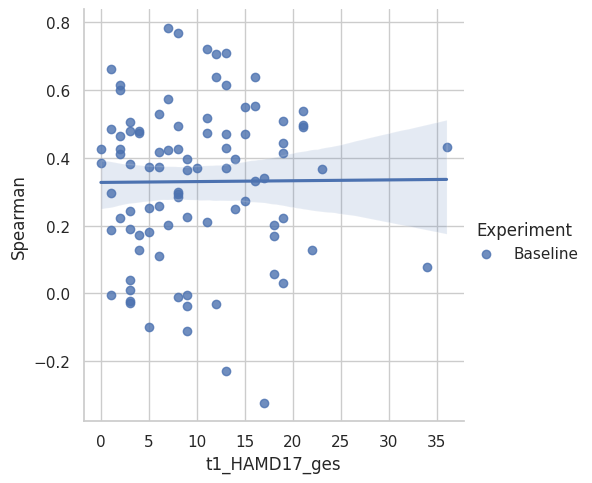

In [ ]:
sns.lmplot(data=long_df[(long_df.Experiment.isin(["Baseline", "Hyperformer All", "Hyperformer Reapprasial NT META", "Hyperformer Reapprasial META"])) & (long_df.group.isin([1,2]))], x="t1_HAMD17_ges", y="Spearman", hue="Experiment")

In [ ]:
correlations = wide_df.corr(method="spearman")

/tmp/ipykernel_1649740/2743425926.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = wide_df.corr(method="spearman")


In [ ]:
long_df

,ID,0,Experiment,Code,group,t1_datum,t1_state_01,t1_state_02,t1_state_03,t1_state_04,...,f4_median,nsyll,npause,dur(s),phonationtime(s),speechrate(nsyll / dur),articulation rate(nsyll / phonationtime),ASD(speakingtime / nsyll),subject,Spearman
0,AE0348,0.294690,Baseline,AE0348,1.0,2022-03-22,0.0,NaN,1.0,"""evtl. wegen Progesteron 400 mg --> Gereiztheit""",...,3606.632181,518,33,123.9,101.958,4.180791,5.080523,0.196830,AE0348,0.294690
1,AE0348,0.241110,Hyperformer meta,AE0348,1.0,2022-03-22,0.0,NaN,1.0,"""evtl. wegen Progesteron 400 mg --> Gereiztheit""",...,3606.632181,518,33,123.9,101.958,4.180791,5.080523,0.196830,AE0348,0.241110
2,AE0348,0.401850,Hyperformer nt,AE0348,1.0,2022-03-22,0.0,NaN,1.0,"""evtl. wegen Progesteron 400 mg --> Gereiztheit""",...,3606.632181,518,33,123.9,101.958,4.180791,5.080523,0.196830,AE0348,0.401850
3,AE0348,0.401850,Hyperformer meta nt,AE0348,1.0,2022-03-22,0.0,NaN,1.0,"""evtl. wegen Progesteron 400 mg --> Gereiztheit""",...,3606.632181,518,33,123.9,101.958,4.180791,5.080523,0.196830,AE0348,0.401850
4,AE0348,0.455430,Hyperformer meta nt embedding,AE0348,1.0,2022-03-22,0.0,NaN,1.0,"""evtl. wegen Progesteron 400 mg --> Gereiztheit""",...,3606.632181,518,33,123.9,101.958,4.180791,5.080523,0.196830,AE0348,0.455430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612,WH1242,-0.005478,Baseline,WH1242,1.0,2022-03-23,0.0,NaN,1.0,"Venlafaxin, 150 mg (täglich, morgens)",...,3815.677420,523,34,125.0,104.240,4.184000,5.017268,0.199312,WH1242,-0.005478
613,WH1242,0.334178,Hyperformer meta,WH1242,1.0,2022-03-23,0.0,NaN,1.0,"Venlafaxin, 150 mg (täglich, morgens)",...,3815.677420,523,34,125.0,104.240,4.184000,5.017268,0.199312,WH1242,0.334178
614,WH1242,-0.060262,Hyperformer nt,WH1242,1.0,2022-03-23,0.0,NaN,1.0,"Venlafaxin, 150 mg (täglich, morgens)",...,3815.677420,523,34,125.0,104.240,4.184000,5.017268,0.199312,WH1242,-0.060262
615,WH1242,0.098610,Hyperformer meta nt,WH1242,1.0,2022-03-23,0.0,NaN,1.0,"Venlafaxin, 150 mg (täglich, morgens)",...,3815.677420,523,34,125.0,104.240,4.184000,5.017268,0.199312,WH1242,0.098610


In [ ]:
phq9_columns = ['t1_phq_1', 't1_phq_2', 't1_phq_3', 't1_phq_4', 't1_phq_5', 't1_phq_6', 't1_phq_7', 't1_phq_8', 't1_phq_9', 't1_phq_sum']
hamd_columns = ['t1_HAMD_01', 't1_HAMD_02', 't1_HAMD_03', 't1_HAMD_04', 't1_HAMD_05', 't1_HAMD_06', 't1_HAMD_07', 't1_HAMD_08', 't1_HAMD_09', 't1_HAMD_10', 't1_HAMD_11', 't1_HAMD_12', 't1_HAMD_13', 't1_HAMD_14', 't1_HAMD_15', 't1_HAMD_16', 't1_HAMD_17', 't1_HAMD_18', 't1_HAMD_19', 't1_HAMD_20', 't1_HAMD_21', 't1_HAMD_22', 't1_HAMD_23', 't1_HAMD_24', 't1_HAMD17_ges']
sek_columns = ['t1_sek_1', 't1_sek_2', 't1_sek_3', 't1_sek_4', 't1_sek_5', 't1_sek_6', 't1_sek_7', 't1_sek_8', 't1_sek_9', 't1_sek_10', 't1_sek_11', 't1_sek_12', 't1_sek_13', 't1_sek_14', 't1_sek_15', 't1_sek_16', 't1_sek_17', 't1_sek_18', 't1_sek_19', 't1_sek_20', 't1_sek_21', 't1_sek_22', 't1_sek_23', 't1_sek_24', 't1_sek_25', 't1_sek_26', 't1_sek_27']
sums = ["t1_sek_sum", "t1_phq_sum", "t1_HAMD17_ges", "group"]

In [ ]:
print(correlations[sums].loc[[x[0] for x in configs]].to_latex())
latex_output = long_df.style.to_latex()
file_path = '/data/eihw-gpu2/pechleba/results/evaluation/ema_eval.tex'  # You can change the file name and path as needed

# Write the LaTeX output to a .tex file
# with open(file_path, 'w') as file:
#     file.write(latex_output)
# Compute correlation between sek and std of mood ratings

/tmp/ipykernel_1649740/3089629991.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(correlations[sums].loc[[x[0] for x in configs]].to_latex())


\begin{tabular}{lrrrr}
\toprule
{} &  t1\_sek\_sum &  t1\_phq\_sum &  t1\_HAMD17\_ges &     group \\
\midrule
SpeechFormer++ Base                                &   -0.255454 &    0.279037 &       0.219478 &  0.219056 \\
SpeechFormer++ Depression Tests                    &   -0.221981 &    0.332565 &       0.263624 &  0.231375 \\
SpeechFormer++ NT                                  &   -0.235210 &    0.251128 &       0.214409 &  0.190156 \\
SpeechFormer++ Embeddings                          &   -0.251051 &    0.336592 &       0.275948 &  0.235027 \\
SpeechFormer++ Depression Tests \& Embedding        &   -0.187460 &    0.281262 &       0.225648 &  0.228822 \\
SpeechFormer++ Depression Tests \& NT               &   -0.204166 &    0.274077 &       0.232711 &  0.228920 \\
SpeechFormer++ Depression Tests \& NT \& Embeddings  &   -0.201944 &    0.244661 &       0.202988 &  0.193091 \\
SpeechFormer++ Base ES = 40 Epochs                 &   -0.273791 &    0.335848 &       0.276059 &  0.288455 \

In [20]:
from sklearn.metrics import mean_squared_error
from itertools import combinations
import numpy as np
import warnings
from scipy.stats import ConstantInputWarning
warnings.filterwarnings('ignore', category=ConstantInputWarning)
warnings.filterwarnings('ignore', category=UserWarning, module='scipy')
from scipy.interpolate import interp1d

# def gini(x):
#     # Mean absolute difference
#     
#     mad = np.abs(np.subtract.outer(x, x)).mean()
#     # Relative mean absolute difference
#     rmad = mad/np.mean(x)
#     # Gini coefficient
#     g = 0.5 * rmad
#     return g

def gini(x):
    """Compute Gini coefficient of array of values"""
    diffsum = 0
    x = np.array([float(value) for value in x["Spearman"].values])
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    result = diffsum / (len(x)**2 * np.mean(x))
    return result.tolist()

def gini_2(v, n_new = 1000):
    """Compute Gini coefficient of array of values"""
    v = [float(value) for value in v["Spearman"].values]
    v = (v - np.min(v)) / (np.max(v) - np.min(v))
    v_abs = np.sort(np.abs(v))
    cumsum_v = np.cumsum(v_abs)
    n = len(v_abs)
    vals = np.concatenate([[0], cumsum_v/cumsum_v[-1]])
    x = np.linspace(0, 1, n+1)
    f = interp1d(x=x, y=vals, kind='previous')
    xnew = np.linspace(0, 1, n_new+1)
    dx_new = 1/(n_new)
    vals_new = f(xnew)
    return 1 - 2 * np.trapz(y=vals_new, x=xnew, dx=dx_new)


def calc_gini_index(rmse_values):
    # Sort the rmse_values
    
    rmse_values["Spearman"] = ( rmse_values["Spearman"] - np.min( rmse_values["Spearman"])) / (np.max( rmse_values["Spearman"]) - np.min( rmse_values["Spearman"]))
    rmse_value_help = [float(value) if value > 0 else 0 for value in rmse_values["Spearman"].values]
    numeric_rmse_values =  sorted(rmse_value_help)

    # Calculate the cumulative sums
    cum_values = np.cumsum(numeric_rmse_values)
    sum_values = cum_values[-1]
    cum_indices = np.cumsum(np.arange(1, len(rmse_values) + 1))

    # Calculate the area under the line of perfect equality
    area_equal = np.trapz(cum_indices, dx=1)

    # Calculate the area under the Lorenz curve
    area_lorenz = np.trapz(cum_values, dx=1)

    # Calculate the Gini index
    gini_index = (area_equal - area_lorenz) / area_equal

    return gini_index

def calc_improvements(baseline, new_predictions):

    diff = new_predictions["Spearman"].values.squeeze() - baseline["Spearman"].values.squeeze()
    baseline = baseline["Spearman"].values.squeeze()
    improved = diff  > 0
    got_worse = diff  < 0

    num_improved = np.sum(improved)
    num_got_worse = np.sum(got_worse)

    # print(diff[improved])
    # print(baseline[improved])
    mean_improvement = np.mean(diff[improved]) / np.mean(baseline[improved])
    mean_loss = np.mean(diff[got_worse]) / np.mean(baseline[got_worse])
    mean_improvement_percent = round((1 + mean_improvement) * 100, 2)
    mean_loss_percent = round(-mean_loss * 100, 2)

    return num_improved.tolist(), num_got_worse.tolist(), mean_improvement_percent, mean_loss_percent
    
predictions_list = []
predictions_base =[]
predictions_adapters = {}


for name, path, result_base_adjusted in configs:

    # if name == "SpeechFormer++ Base":
    #     _, predictions_base = load_predictions(path, result_base_adjusted=result_base_adjusted, patient_groups=["PatientInnen"])
    #     predictions_base = predictions_base[["ID", "true", "prediction"]]
    #     # rmse = predictions_base.groupby('ID').apply(lambda group: np.sqrt(mean_squared_error(group['true'], group['prediction'])))
    #     rmse = predictions_base.groupby('ID').apply(lambda group: mean_squared_error(group['true'], group['prediction']))
    #     predictions_base= rmse

    _, predictions_adapters[name] = load_predictions(path, result_base_adjusted=result_base_adjusted, patient_groups=["PatientInnen"])
    # # predictions_adapters[name] = predictions_adapters[name][["ID", "true", "prediction"]]
    # # rmse = predictions_adapters[name].groupby('ID').apply(lambda group: mean_squared_error(group['true'], group['prediction']))
    # # predictions_adapters[name]= rmse

    # predictions_adapters[name] = predictions_adapters[name][(predictions_adapters[name]["patientGroup"].isin(["Patienten"]))]

    # predictions_adapters[name] = general_metrics(experiment=path, result_base_adjusted=result_base_adjusted)

    # SPEARMAN

    
    num_values = ["true", "prediction"]

    predictions_adapters[name] = (
       predictions_adapters[name].groupby(["ID", "date", "patientGroup"])[num_values]
        .mean()
        .reset_index()
    )
    
    predictions_adapters[name] = (
        predictions_adapters[name][["ID", "prediction", "true"]]
        .groupby(["ID"])
        .apply(lambda x: spearmanr(x["prediction"], x["true"])[0])
        .sort_values()
        .sort_index(level="Experiment", sort_remaining=False)
        .reset_index()
    )

# predictions_base =  pd.DataFrame(predictions_base)
# predictions_adapters =  pd.DataFrame(predictions_adapters)

gini_index = {}
gini_winners_amount = {}
gini_winners_percent = {}
gini_losers_amount = {}
gini_losers_percent = {}

# Calculate the baseline Gini index
# predictions_base.columns = ["rmse"]
predictions_help = pd.DataFrame.from_dict(predictions_adapters["Baseline"])
# predictions_help.columns = [["rmse"]]
predictions_help.columns = [["ID", "Spearman"]]
predictions_baseline = predictions_help
# print(predictions_help)
baseline_gini_index= gini(predictions_help)
# print(f"Model: baseline\nGini Index: {gini_index['baseline']}")
for key in predictions_adapters.keys():
   
    predictions_help = pd.DataFrame.from_dict(predictions_adapters[key])
    # predictions_help.columns = [["rmse"]]
    # SPEARMAN
    predictions_help.columns = [["ID", "Spearman"]]
    
    # print(predictions_help)
    gini_index[key] = gini(predictions_help)
    # gini_index[key] = calc_gini_index(predictions_help)
    # gini_index[key] = gini_2(predictions_help)
    gini_winners_amount[key], gini_losers_amount[key],gini_winners_percent[key], gini_losers_percent[key] = calc_improvements(predictions_baseline, predictions_help)

    # Calculate the Gini coefficient relative to the baseline
    # gini_index[key] /= baseline_gini_index

    # print(f"Model: {key} Gini Index: {gini_index[key]}")
    # print(f"Model: {key} Winners Amount: {gini_winners_amount[key]}\nWinners Percent: {gini_winners_percent[key]}\nLosers Amount: {gini_losers_amount[key]}\nLosers Percent: {gini_losers_percent[key]}\n")


data = {
    "Model": list(gini_index.keys()),
    "Winners Amount": list(gini_winners_amount.values()),
    "Winners Percent": list(gini_winners_percent.values()),
    "Losers Amount": list(gini_losers_amount.values()),
    "Losers Percent": list(gini_losers_percent.values())
}

# Create DataFrame
df = pd.DataFrame(data)

df.fillna('--', inplace=True)

# Convert DataFrame to LaTeX table
latex_table = df.to_latex(index=False)

print(latex_table)

/data/eihw-gpu2/pechleba/results/speechformer_base//all_recordings_ema_e60_es15/evaluation/ probably not a fold directory.


/tmp/ipykernel_92388/2032256862.py:124: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: spearmanr(x["prediction"], x["true"])[0])


/data/eihw-gpu2/pechleba/results/speechformer_adapter//all_recordings_ema_e60_es15_adapter_depression_tests/evaluation/ probably not a fold directory.


/tmp/ipykernel_92388/2032256862.py:124: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: spearmanr(x["prediction"], x["true"])[0])
/tmp/ipykernel_92388/2032256862.py:124: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: spearmanr(x["prediction"], x["true"])[0])
/tmp/ipykernel_92388/2032256862.py:124: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. Thi

\begin{tabular}{lrlrl}
\toprule
Model & Winners Amount & Winners Percent & Losers Amount & Losers Percent \\
\midrule
Baseline & 0 & -- & 0 & -- \\
Tests & 29 & 142.950000 & 16 & 16.040000 \\
NT & 17 & 116.490000 & 28 & 14.330000 \\
Embed & 30 & 139.680000 & 15 & 22.060000 \\
Test&Embed & 32 & 140.170000 & 13 & 21.440000 \\
Tests&NT & 34 & 124.410000 & 11 & 22.580000 \\
Tests&NT&Embed & 25 & 117.580000 & 20 & 16.630000 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_92388/2032256862.py:124: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: spearmanr(x["prediction"], x["true"])[0])
/data/eihw-gpu1/pechleba/SpeechFormer/.devenv/state/venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/eihw-gpu1/pechleba/SpeechFormer/.devenv/state/venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_92388/2032256862.py:179: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future v

In [ ]:
print(list(correlations.columns))

[0, 'Hyperformer meta nt embedding', '0_x', 'Hyperformer meta nt', '0_y', 'Hyperformer nt', '0_x', 'Hyperformer meta', '0_y', 'Baseline', 'group', 't1_state_01', 't1_state_03', 't1_state_05', 't1_state_07', 't1_state_08', 't1_state_09', 't1_state_10', 't1_state_11', 't1_state_12', 't1_HAMD_01', 't1_HAMD_02', 't1_HAMD_03', 't1_HAMD_04', 't1_HAMD_05', 't1_HAMD_06', 't1_HAMD_07', 't1_HAMD_08', 't1_HAMD_09', 't1_HAMD_10', 't1_HAMD_11', 't1_HAMD_12', 't1_HAMD_13', 't1_HAMD_14', 't1_HAMD_15', 't1_HAMD_16', 't1_HAMD_17', 't1_HAMD_18', 't1_HAMD_19', 't1_HAMD_20', 't1_HAMD_21', 't1_HAMD_22', 't1_HAMD_23', 't1_HAMD_24', 't2_state_01', 't2_state_03', 't2_state_05', 't2_state_07', 't2_state_08', 't2_state_09', 't2_state_10', 't2_state_11', 't2_state_12', 't2_HAMD_01', 't2_HAMD_02', 't2_HAMD_03', 't2_HAMD_04', 't2_HAMD_05', 't2_HAMD_06', 't2_HAMD_07', 't2_HAMD_08', 't2_HAMD_09', 't2_HAMD_10', 't2_HAMD_11', 't2_HAMD_12', 't2_HAMD_13', 't2_HAMD_14', 't2_HAMD_15', 't2_HAMD_16', 't2_HAMD_17', 't2_HAMD_

In [ ]:
df["t1_HAMD24_ges"] = df[list(filter(lambda x: "t1_HAMD" in x, list(df.columns)))].apply(lambda x: sum(x), axis=1)

In [ ]:
df[["Code", "t1_HAMD17_ges"]].sort_values(by="t1_HAMD17_ges").to_csv("hamd17.csv", index=False)

: 